## IDENTIFICATION

In [1]:
import csv
import subprocess
import pandas as pd
from cStringIO import StringIO
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
sb.set_style("whitegrid")
import collections
import numpy as np
from scipy import stats
import statsmodels.sandbox.stats.multicomp as mc
%matplotlib inline 
from qvality import read_msgfp_csv, target_and_null_peptides_4_qvality, read_qvality_result
from operator import add
from IPython.display import display, HTML
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist,cdist
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.manifold import TSNE

In [2]:
#this_dir = os.getcwd() #for use on python console
this_dir = "/home/vitalv/cyano_dataset_20170421/" #for use on this notebook

#REad number of proteins from msgfplus:
msgfplus = os.path.join(this_dir, "msgfplus")
qvality_dir = os.path.join(this_dir, "qvality")

#get msgfp peptides (Not PSM resulting from MSGFPlusAdapter) df filtered using qvality results:
msgfp_csv_files = [f for f in os.listdir(msgfplus) if f.endswith(".csv")]
run_prots = {} 
peptides = {}
for msgfp_csv in msgfp_csv_files:
	sample_name = msgfp_csv.split(".")[0] #msgfp_file_basename
	msgfp_psms = read_msgfp_csv(os.path.join(msgfplus, msgfp_csv))
	msgfp_peptides, msgfp_null_peptides = target_and_null_peptides_4_qvality(msgfp_psms) #psms are collapsed to one (best scoring psm) peptide
	#qvality_out_file = run_qvality(msgfp_file_basename, msgfp_peptides, msgfp_null_peptides)
	qvality_out_file = os.path.join(qvality_dir, (sample_name + "_qvality_out.csv"))
	msgfp_qvality = read_qvality_result(qvality_out_file)
	#ideally get one new df from qvality df and original peptides df by merging on score:
	#or I could just sort by score and add the qvalue column to the original peptides df
	msgfp_peptides = msgfp_peptides.sort_values(by='score')
	msgfp_peptides["qval"] = msgfp_qvality["q-value"].values
	#then filter q-val < 0.01 and decoy proteins
	msgfp_peptides = msgfp_peptides[msgfp_peptides["qval"]<0.01]
	msgfp_peptides = msgfp_peptides[~msgfp_peptides.accessions.str.contains('XXX')]
	#discard also all shared peptides by removing from the list all accessions that contain ";":
	msgfp_peptides = msgfp_peptides[~msgfp_peptides.accessions.str.contains(";")]
	print sample_name
	print("Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): %s"%len(msgfp_peptides))
	print("Unique proteins those peptides map to: %s\n"%len(msgfp_peptides.accessions.unique()))
	run_prots[sample_name] = list(msgfp_peptides.accessions.unique())
	peps = msgfp_peptides.groupby("accessions").size().value_counts().to_dict() # num of proteins with 1, 2, 3, ... peptides 
	peptides[sample_name] = peps



pep_items = sorted(peptides.items())
#sorted(peptides.items()) #below, does not work the way I want Cyano_1000_R1 will be sorted before Cyano_100_R1, and Cyano_200_ will be sorted before Cyano_60
#It will sort Cyano_1000_RX, Cyano_100_RX, Cyano_200_RX, Cyano_300_RX, Cyano_60_RX. Just change positions between the 60 and the 1000 replicates: 
my_sorted_pep_items = pep_items[-4:]+pep_items[4:-4]+pep_items[:4]

peptides = collections.OrderedDict(my_sorted_pep_items)
#run_prots = collections.OrderedDict(sorted(run_prots.items()))

#run_prots_items = sorted(run_prots.items())
#my_sorted_run_prot_items = run_prots_items[-4:]+run_prots_items[4:-4]+run_prots_items[:4]
run_prots = collections.OrderedDict(sorted(run_prots.items()))
run_counts = {}
for run, prots in run_prots.items():
	run_counts[run] = len(prots)
run_counts = collections.OrderedDict(sorted(run_counts.items()))


20170419_GM_Cyano_200_R4_BB4_01_2478
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 2673
Unique proteins those peptides map to: 1203

20170419_GM_Cyano_100_R2_BA6_01_2471
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 3351
Unique proteins those peptides map to: 1246

20170419_GM_Cyano_300_R3_BB7_01_2482
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 2621
Unique proteins those peptides map to: 1172

20170419_GM_Cyano_100_R4_BA8_01_2473
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 2824
Unique proteins those peptides map to: 1019

20170419_GM_Cyano_60_R4_BA4_01_2468
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 3325
Unique proteins those peptides map to: 1259

20170419_GM_Cyano_60_R2_BA2_01_2466
Unique peptides (excluding decoy hits, excluding shared peptides, q-val < 0.01): 2932
Unique proteins those peptides map to: 

In [5]:
def autolabel(ax, rects):
	# attach text label with bar height in barplot
	for rect in rects:
		height = rect.get_height()
		ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=12)




#Stacked bar plot showing number peptides supporting protein detection #######################################################
def stacked_pep_plot(peptides, n_replica=None):
	sb.set_style("whitegrid", {'axes.grid' : False})

	'''
	Draws barplot where each bar is a map/run and is stacked to show number of proteins with 1 peptide, 2 peptides, etc...
	argument peptides is a dict (OrderedDict) where keys are the runs/maps, and values are a dict with num of proteins with 1, 2, 3, ... peptides
	('Run1', {1: 594, 2: 187, 3: 70, 4: 31, 5: 11, 6: 5, 7: 5, 8: 1, 9: 2, 10: 2, 13: 1}),
	('Run2', {1: 594, 2: 174, 3: 69, 4: 25, 5: 13, 6: 7, 7: 3, 8: 3, 9: 1, 10: 1}),

	'''
	if n_replica and len(peptides) % n_replica != 0:
		print "Can't group runs in groups of %s !"%n_replica
		return None

	prots_per_run = [sum(peptides[peptides.keys()[i]].values()) for i in range(len(peptides))]

	f, ax = plt.subplots(1, figsize=(16,10))
	bar_width = 0.60
	bar_l = range(1,len(peptides)+1)
	if n_replica: bar_l = range(1, len(peptides)/n_replica + 1)
	tick_pos = [i+(bar_width/2) for i in bar_l] # positions of the x-axis ticks (center of the bars as bar labels)
	colors=["#F4561D", "#F1911E", "#F1BD1A", "#F49542", "#468c1a"]

	if not n_replica:
		for run in peptides.keys():
			cumulative = 0
			for npep, nprot in peptides[run].items()[0:4]:
				cumulative += nprot
				bottom = cumulative - nprot
				x = bar_l[peptides.keys().index(run)]
				rects = ax.bar(x, height=nprot, width=bar_width, bottom=bottom, label=npep, alpha=0.7, color=colors[npep-1])
				if npep == 1: autolabel(ax, rects) 
			sum_other = sum([nprot for npep, nprot in peptides[run].items()[4:-1]])
			bottom = bottom + peptides[run][4]
			ax.bar(x, sum_other, width=bar_width, bottom=bottom, label='>4', alpha=0.7, color="#468c1a")
		for bar in plt.bar(np.arange(len(peptides)), prots_per_run, alpha=0, width=0.75):#trick! draw invisible bars (alpha=0) to annotate the height:
			x = bar.get_x() + 1 + bar.get_width()/2.
			height = bar.get_height()
			plt.text(x, 1.01*height, '%d'%int(height), ha='center', va='bottom', size=12)
		#xticks_labels = [p.split("_")[3]+p.split("_")[4] for p in peptides.keys() ] #only works for cyano 20170421 dataset
		plt.xticks(tick_pos, "", ha='right', size=14) #, rotation=45
	else: 
		bottom = [0]*(len(peptides)/n_replica)
		for i in range(1,5): #draw in batches bars for proteins w 1 pep, bars for proteins w 2 peps...
			nprots_w_ipeps = [d[i] for d in peptides.values()]
			nprots_w_ipeps_avg = [sum(nprots_w_ipeps[j:j+n_replica])/n_replica for j in range(0, len(nprots_w_ipeps), n_replica)]
			ax.bar(bar_l, nprots_w_ipeps_avg, width=bar_width, bottom=bottom, label=i, alpha=0.7, color=colors[i-1])
			bottom = map(add, bottom, nprots_w_ipeps_avg)
		sum_other = [sum(peptides.values()[i].values()[4:-1]) for i in range(len(peptides))]
		sum_other_avg = [sum(sum_other[i:i+n_replica])/n_replica for i in range(0, len(peptides), n_replica)]
		ax.bar(bar_l, nprots_w_ipeps_avg, width=bar_width, bottom=bottom, label='>4', alpha=0.7, color="#468c1a")
		#tick_labels = ["avg_%s" % i for i in range(1,(len(peptides)/n_replica)+1)]
		tick_labels = ["60uE m-2 s-1 (avg)", '100uE m-2 s-1 (avg)', '200uE m-2 s-1 (avg)', '300uE m-2 s-1 (avg)', '1000uE m-2 s-1 (avg)' ]
		plt.xticks(tick_pos, tick_labels, ha='center', size=14) #, rotation=45

	handles, labels = plt.gca().get_legend_handles_labels()
	by_label = collections.OrderedDict(zip(labels, handles))
	plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.15,0.7), title="Num peptides")
	plt.ylabel("# Proteins", fontsize=14)
	plt.yticks(fontsize=14)
	plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width]) # Set a buffer around the edge
	plt.gcf().subplots_adjust(bottom=0.37, right=0.88)
	sb.despine(left=True)
	plt.show()



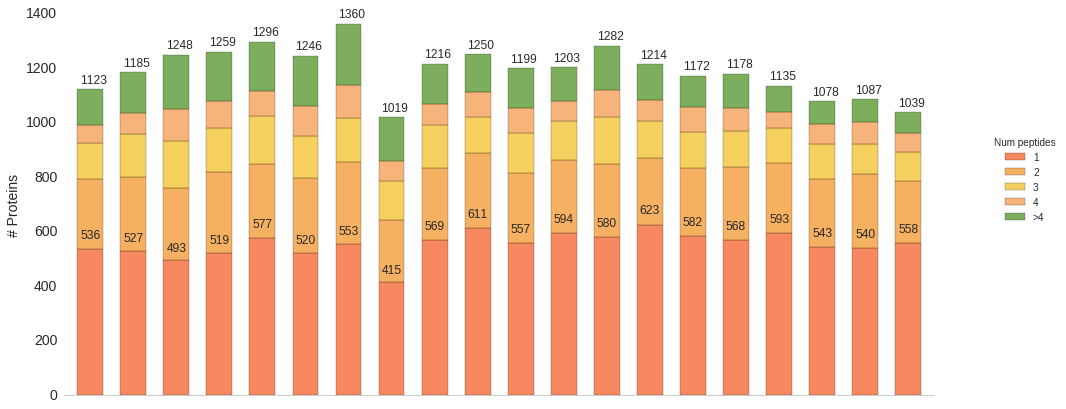

In [6]:
stacked_pep_plot(peptides)

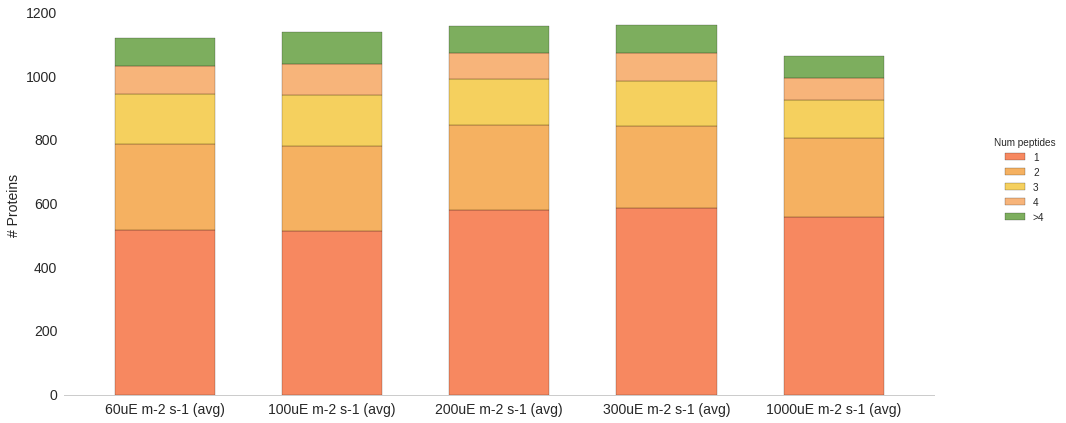

In [7]:
stacked_pep_plot(peptides, n_replica=4)

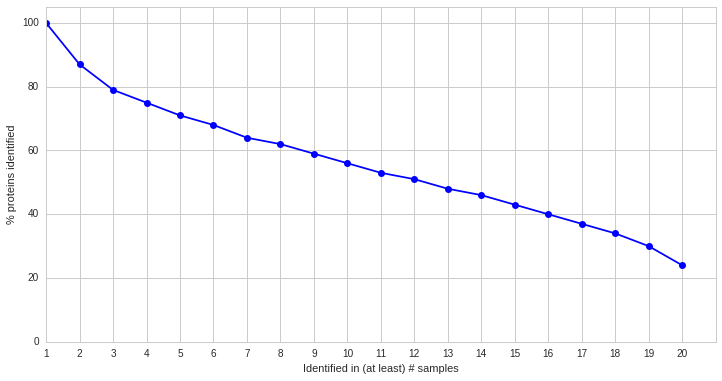

In [9]:
#Note this is identification (unlike the similar plot where I get QUANTIFIED peptides accross all runs)
sb.set_style("whitegrid")

#In this case THERE IS MS2 peptide evidence supporting identification. That's why is lower than in the missing value recover plots from DeMixQ!
all_prots = []
all_prots = [prot for sublist in run_prots.values() for prot in sublist]
#Get number of proteins detected in 1 run, in 2 runs, etc...
#(does not include groups of proteins containing more than one accession -separated by ";" )
prot_freq = collections.Counter(all_prots)
prot_count = collections.Counter(prot_freq.values())
p = prot_count.values()
prot_ids_in_runs = []
#Get CUMULATIVE number of proteins detected in 1 run, 2 runs, etc...
for i in range(len(p)):
	prot_ids_in_runs.append(sum([s for s in p[i:len(p)]]))
percent_prot_ids_in_runs = [i*100/max(prot_ids_in_runs) for i in prot_ids_in_runs]
fig = plt.figure(figsize=(12,6))
plt.plot(percent_prot_ids_in_runs, "bo-")
plt.ylim([0,105])
plt.xticks(range(len(percent_prot_ids_in_runs)), [i +1 for i in range(len(p))])
plt.xlabel("Identified in (at least) # samples")
plt.ylabel("% proteins identified")

#### categories

In [10]:
genes = "/home/vitalv/database/genes.txt"
genes_df = pd.read_csv(genes, delimiter="\t", header=None)
genes_df.columns = ["DataSourceName", "geneID", "Chromosome", "Start", "Stop","Strand", "Description"]

category_f = "/home/vitalv/database/category.txt"
category_df = pd.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]

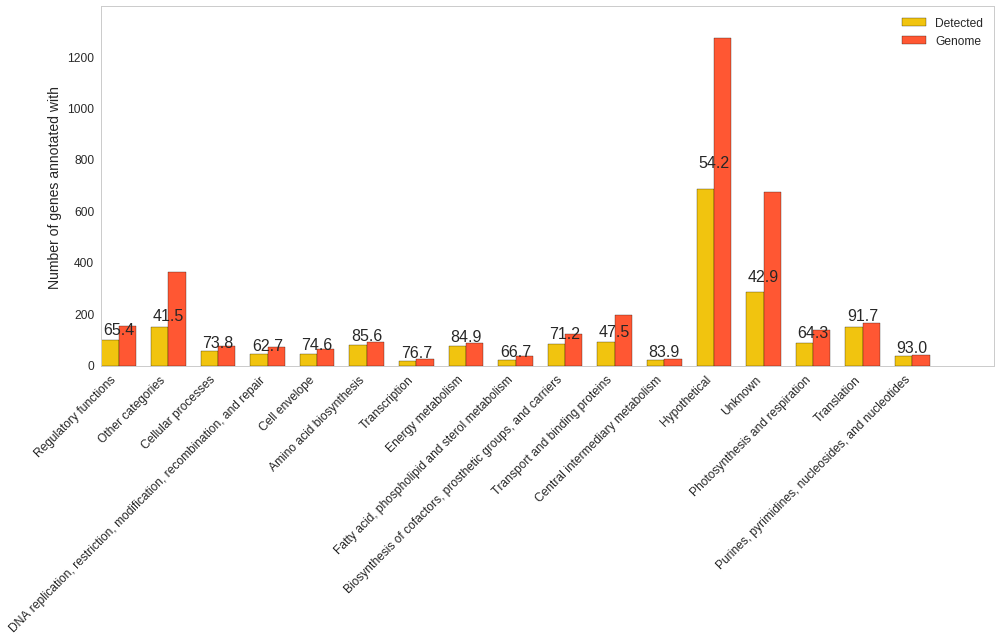

In [11]:
#Bar Plot categories of the detected proteins compared to categories of the whole genome ###############################################

sb.set_style("whitegrid", {'axes.grid' : False})

def autolabel(ax, rects):
	# attach text label with bar height in barplot
	for rect in rects:
		height = rect.get_height()
		ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=12)

my_prots_categories = pd.DataFrame()
my_prots_categories["geneID"] = list(set(all_prots))
#category_f = "/home/vitalv/database/category.txt"
#category_df = pd.read_csv(category_f, delimiter="\t", header=None)
#category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
cols = ["geneID", "definition", "first_category_name", "second_category_name"]
my_prots_categories_df = pd.merge(my_prots_categories, category_df[cols], left_on='geneID', right_on='geneID', how='left')
#Categories frequencies for identified set of proteins(genes) and for entire genome:
category_data_identified = my_prots_categories_df.groupby("first_category_name").size().to_dict()
category_data_genome = category_df.groupby("first_category_name").size().to_dict()

ind = np.arange(len(category_data_identified))  # the x locations for the groups
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
categories_identified, categories_genome = [], []
tick_labels = []
for cat, num in category_data_identified.items():
	categories_identified.append(category_data_identified[cat])
	categories_genome.append(category_data_genome[cat])
	tick_labels.append(cat)
rects1 = ax.bar(ind, categories_identified, width, color='#F1C40F')
rects2 = ax.bar(ind + width, categories_genome, width, color='#FF5733')
fractions = []
for d, g in zip([r.get_height() for r in rects1], [r.get_height() for r in rects2]):
	fractions.append(round((d*100)/g,1))
for rect in rects1:
	ax.text(rect.get_x() + rect.get_width(), 1.1*rect.get_height(), fractions[rects1.index(rect)], ha='center', va='bottom', size=16)
ax.set_ylabel("Number of genes annotated with", fontsize=14)
ax.set_yticklabels(range(0,1400,200), fontsize=12)
ax.set_xticks(ind + width)
ax.set_xticklabels(tick_labels, fontsize="12")
ax.legend((rects1[0], rects2[0]), ('Detected', 'Genome'), fontsize=12)
#autolabel(ax, rects1)
#autolabel(ax, rects2)
plt.gcf().subplots_adjust(bottom=0.4)
plt.xticks(ind+width, tick_labels, ha='right', rotation=45)
plt.show()


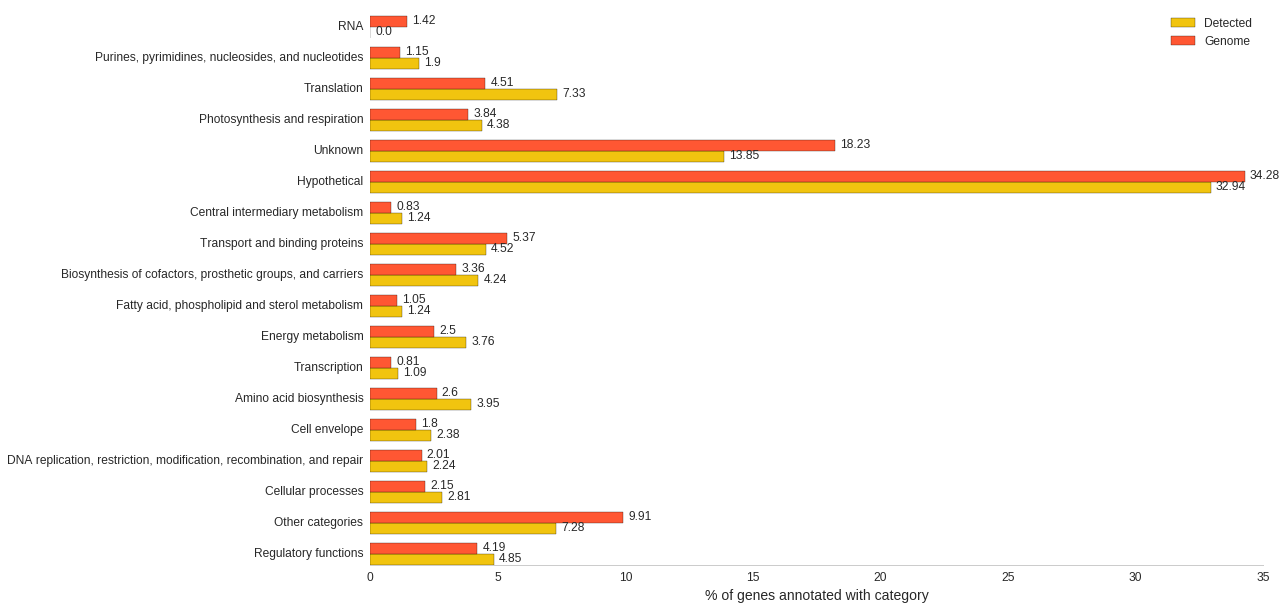

In [14]:
#Similar thing but expressed as fractions (For ex: 4% of the proteins are annotated with "Translation" in the identified set; 
#whereas that % is 7 in the total genome)
sb.set_style("whitegrid", {'axes.grid' : False})


category_data_genome_percent = {}
for cat, num in category_data_genome.items():
	category_data_genome_percent[cat] = round(float(num)/sum(category_data_genome.values()) * 100,2)
category_data_identified_percent = {}
for cat, num in category_data_identified.items():
	category_data_identified_percent[cat] = round(float(num)/sum(category_data_identified.values()) * 100,2)
_categories = [cat for cat in category_data_genome_percent.keys() if cat not in category_data_identified_percent.keys()]
for c in _categories:	category_data_identified_percent[c] = 0

def autolabel_width(rects):
	# attach text label with bar height in barplot
	for rect in rects:
		width = rect.get_width()
		ax.text(width+0.2, rect.get_y(), width,  ha='left', va='bottom', size=12)

ind = np.arange(len(category_data_identified_percent))  
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
categories_identified, categories_genome = [], []
tick_labels = []
for cat, num in category_data_genome_percent.items():
	categories_identified.append(category_data_identified_percent[cat])
	categories_genome.append(category_data_genome_percent[cat])
	tick_labels.append(cat)
rects1 = ax.barh(ind, categories_identified, width, color='#F1C40F')
rects2 = ax.barh(ind + width, categories_genome, width, color='#FF5733')
ax.set_xlabel("% of genes annotated with category", fontsize=14)
ax.set_xticklabels(range(0,40,5), fontsize=12)
ax.set_yticks(ind + width)
ax.set_yticklabels(tick_labels, fontsize="12")
ax.legend((rects1[0], rects2[0]), ('Detected', 'Genome'), fontsize=12)
autolabel_width(rects1)
autolabel_width(rects2)
sb.despine(left=True, bottom=False)
plt.show()

## QUANTIFICATION

In [15]:
num_samples = 5
num_replica = 4

diffacto_out = "/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_proteins.tsv"
#copy ProteinQuantifier output from /media/ProteomicsCyano
feature_pip_prots = '/home/vitalv/cyano_dataset_20170421/ProteinQuantifier/protein_quant_all.csv'
feature_pip = pd.read_csv(feature_pip_prots, skiprows=3, delimiter="\t")
abundance_cols = [c for c in feature_pip.columns if c.startswith("abundance")]
#percent_feature_pip = [i*100/max(feature_pip_count) for i in feature_pip_count]
#filter by proteins that are detected in at least one replica of each sample:
ix = np.min([np.mean(feature_pip[i].values, axis=1) for i in np.array(abundance_cols).reshape(num_samples, num_replica)], axis=0) > 0 
feature_pip = feature_pip[ix]

print "Proteins identified in at least one replica of each of the conditions %s (ProteinQuantifier)" % len(feature_pip)

Proteins identified in at least one replica of each of the conditions 1054 (ProteinQuantifier)


#### ANOVA and categories plot for significant proteins

Number of proteins with significant change in abundance (ANOVA q < 0.05): 501


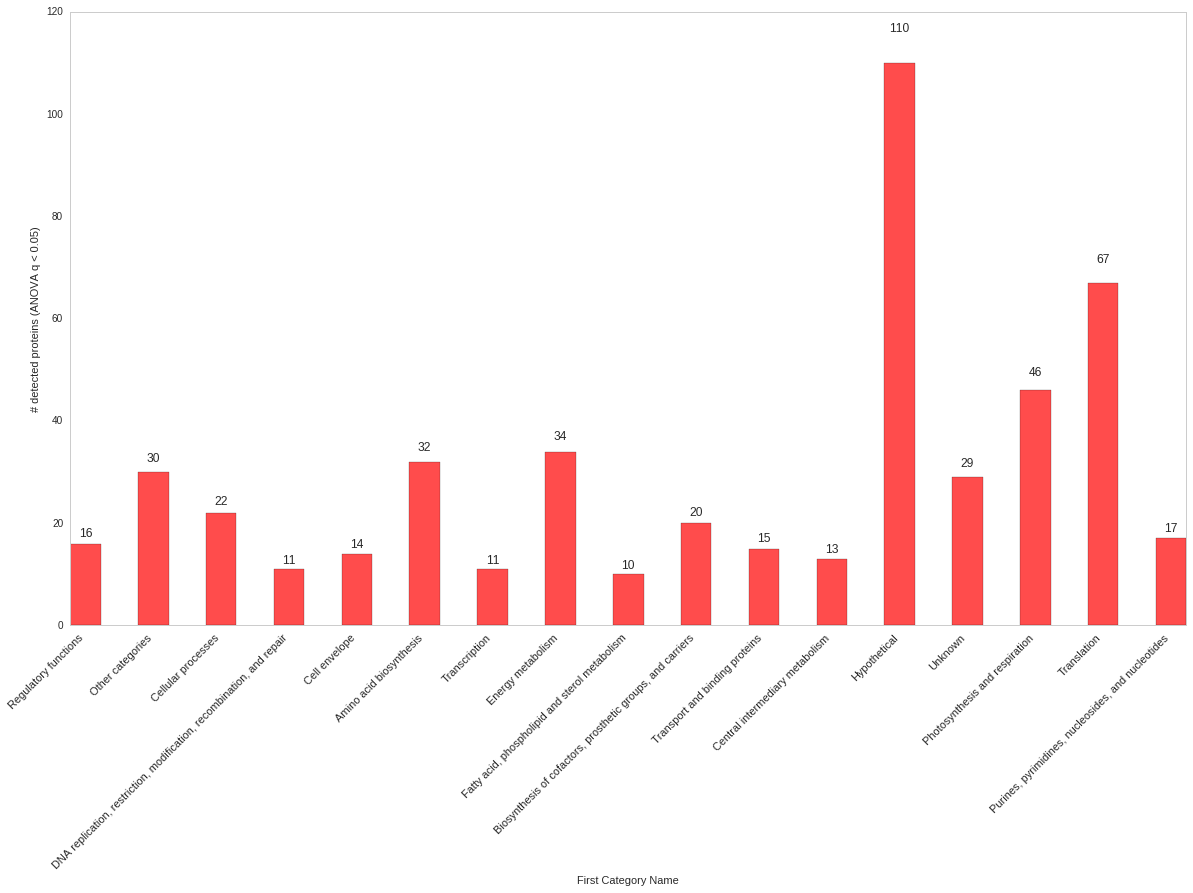

In [17]:
diffacto_out = "/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_proteins.tsv"
diffacto = pd.read_csv(diffacto_out, delimiter="\t")
data = pd.merge(diffacto, genes_df[["geneID","Description"]], left_on="Protein", right_on="geneID", how='left')
data = data[data["S/N"] > -20]#Filter out non - informative proteins S/N greater than -20. See Diffacto manuscript
samples = [c for c in data.columns if "_" in c]

#num_samples = 5
#num_replica = 4
for i in np.array(samples).reshape(num_samples, num_replica):
	median = data[i].median(axis=1)
	avg = data[i].mean(axis=1)
	data[i[0].split("_")[0]+"_median"] = median
	data[i[0].split("_")[0]+"_mean"] = avg

means = ["60_mean", "100_mean", "200_mean", "300_mean", "1000_mean"]
medians = ["60_median", "100_median", "200_median", "300_median", "1000_median"]
data = data[["Protein"]+ samples + means + medians]

for index, row in data.iterrows():
	#Get pandas df for each prot with columns dependent_variable, factor_1 and factor_2:
	prot_df = pd.DataFrame(columns=["dependent_variable", "group"])
	prot_df.group = [ s.split("_")[0] for s in samples ]
	prot_df.dependent_variable = row[samples].values
	k = len(pd.unique(prot_df.group))  # number of samples
	N = len(prot_df.values)  # samples times replica
	n = prot_df.groupby('group').size()[0] #num_replica
	DFbetween = k - 1
	DFwithin = N - k
	DFtotal = N - 1
	grand_mean = prot_df.dependent_variable.mean()
	SSbetween = sum( [ n * (prot_df[prot_df.group == g].dependent_variable.mean() - grand_mean)**2 for g in set(list(prot_df.group))] )
	sum_y_squared = sum([value**2 for value in prot_df['dependent_variable'].values])
	SSwithin = sum_y_squared - sum(prot_df.groupby('group').sum()['dependent_variable']**2)/n
	SStotal = sum_y_squared - (prot_df['dependent_variable'].sum()**2)/N
	MSbetween = SSbetween/DFbetween
	MSwithin = SSwithin/DFwithin
	F = MSbetween/MSwithin
	p = stats.f.sf(F, DFbetween, DFwithin)
	data.loc[index, 'p_val'] = p

#Convert p-values to q-values:
#1 write p-values to a .txt
data.p_val.to_csv("anova_p_values.txt", index=False)
#2 run qvality
qvality_cmd = "qvality anova_p_values.txt -o anova_qvality_out.txt"
proc = subprocess.Popen(qvality_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
out,err = proc.communicate()
#3 read qvality output 
with open('anova_qvality_out.txt') as f:
	lines = f.readlines()
qvalues = [line.rstrip('\n').split("\t")[-1] for line in open('anova_qvality_out.txt')][1:]
#4 append qvalues to my data df
data = data.sort_values(by='p_val')
data["q_val"] = [float(q) for q in qvalues]

#category_f = "/home/vitalv/cyano/category.txt"
#category_df = pd.read_csv(category_f, delimiter="\t", header=None)
#category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
category_cols = ["geneID", "definition", "first_category_name", "second_category_name"]
data = pd.merge(data, category_df[category_cols], left_on="Protein", right_on="geneID", how='left')

data.Protein = [p.split(";")[0] for p in data.Protein]
data_anova = data[data["q_val"] < 0.05] 


category_data_anova = data_anova.groupby("first_category_name").size().to_dict()

index = np.arange(1,len(set(data_anova.first_category_name)))
counts = category_data_anova.values()
width = 0.45
fig = plt.figure()
fig.set_size_inches(20,11)
plt.xlabel("First Category Name")
xtickspos = [i+(width/2) for i in index]
plt.xticks(xtickspos, category_data_anova.keys(),  ha='right', rotation=45, fontsize=11)
plt.ylabel("# detected proteins (ANOVA q < 0.05)")
bars = plt.bar(index, counts, width, color='r', alpha=0.7)
for bar in bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=12)
    
print "Number of proteins with significant change in abundance (ANOVA q < 0.05): %s"% len(data_anova)

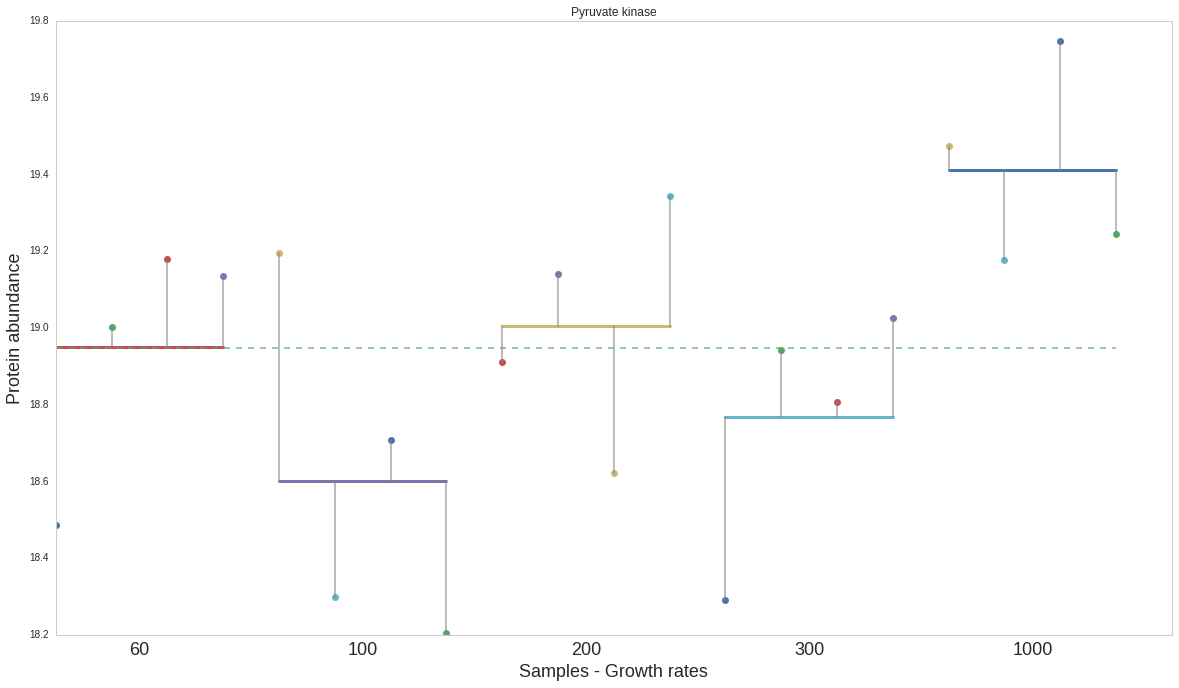

In [18]:
#PLOT Single Test ANOVA ########################################################################
#Use an example of one protein with significant change in abundance (q-val < .05) to illustrate ANOVA
sb.set_style("whitegrid", {'axes.grid' : False})

pyr_kin = data_anova[data_anova.definition == "pyruvate kinase"]
prot_df = pd.DataFrame(columns=["dependent_variable", "group"])
prot_df.group = samples
prot_df.dependent_variable = [v for v in pyr_kin[samples].values[0]]
grand_mean = pyr_kin[samples].values.mean()
fig = plt.figure()
fig.set_size_inches(20,11)
for i in range(len(samples)):
	plt.plot(i, pyr_kin[samples].values[0][i], 'o')
for i in range(0, len(samples), 4):
	s_mean = samples[i].split("_")[0]+"_mean"
	plt.plot([i, i+3], [pyr_kin[s_mean].values[0]]*2, lw=3)
for a, b in zip(range(20), ["60_mean"]*4 + ["100_mean"]*4 + ["200_mean"]*4 + ["300_mean"]*4 + ["1000_mean"]*4):
	plt.plot([a,a], [pyr_kin[samples].values[0][a], pyr_kin[b]], color='gray', alpha=0.6)
plt.plot([0,19], [grand_mean, grand_mean], '--', alpha=0.7)
ticks = [1.5, 5.5, 9.5, 13.5, 17.5]
tick_labels = [60, 100, 200, 300, 1000]
plt.xticks(ticks, tick_labels, size=18)
plt.xlabel("Samples - Growth rates", size=18)
plt.ylabel("Protein abundance", size=18)
plt.title("Pyruvate kinase")

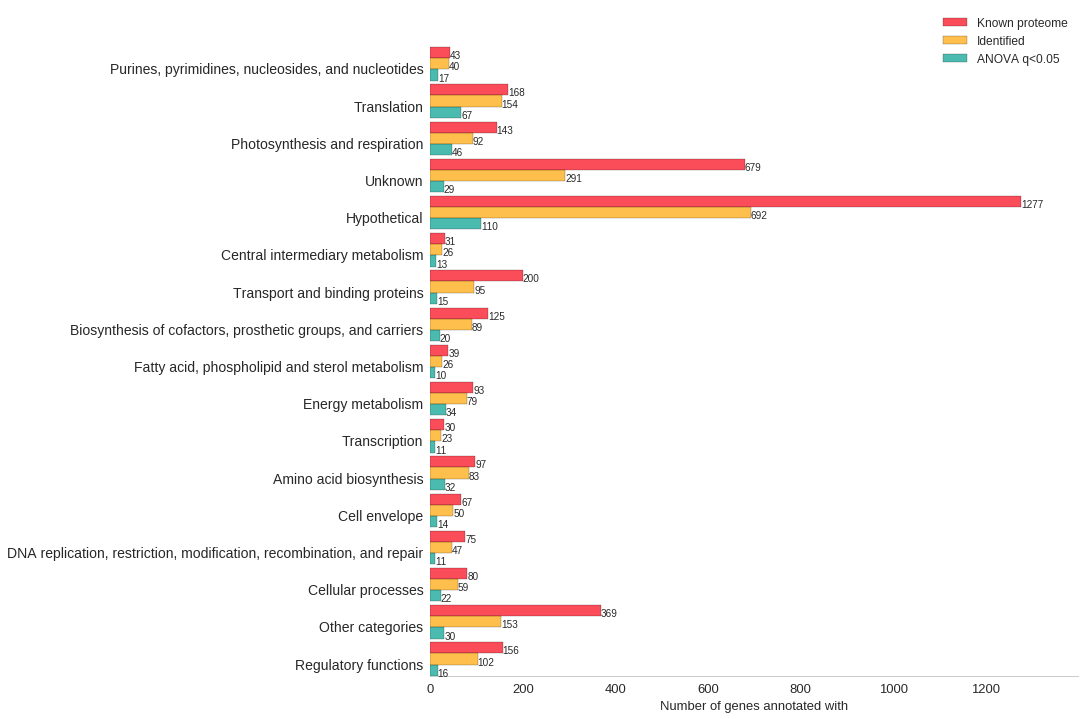

In [20]:
#Category Bar Plot with 3 bars per category: 1 ANOVAq<05 proteins, 2 Detected Proteins, 3 Genome ####################

def autolabel_h(rects):
	# attach text label with bar height in barplot
	for rect in rects:
		width = rect.get_width()
		ax.text(width, rect.get_y(), '%d'%int(width), size=10)
        
if 'RNA' in category_data_genome: del category_data_genome["RNA"]
#category_data_genome = category_df.groupby("first_category_name").size().to_dict()
#category_data_anova = data.groupby("first_category_name").size().to_dict()
#category_data_identified = my_prots_categories_df.groupby("first_category_name").size().to_dict()
ind = np.arange(len(category_data_genome))  # the x locations for the groups
width = 0.30# the width of the bars
fig, ax = plt.subplots(1, figsize=(18,12))
categories_anova, categories_identified, categories_genome = [], [], []
tick_labels = []
for cat, num in category_data_genome.items():
	categories_anova.append(category_data_anova[cat])
	categories_identified.append(category_data_identified[cat])
	categories_genome.append(category_data_genome[cat])
	tick_labels.append(cat)
rects3 = ax.barh(ind + 2*width, categories_genome, width, color='#F80012', alpha=0.7)
rects2 = ax.barh(ind + width, categories_identified, width, color='#FFA500', alpha=0.7)
rects1 = ax.barh(ind , categories_anova, width, color='#009E8E', alpha=0.7)
ax.set_xlabel("Number of genes annotated with", fontsize=13)
ax.set_xticklabels(range(0,1400,200), fontsize=13)
ax.set_yticks(ind + width)
ax.set_yticklabels(tick_labels,  fontsize=14)#rotation=90,
ax.legend((rects3[0], rects2[0], rects1[0]), ('Known proteome', 'Identified', 'ANOVA q<0.05'), fontsize=12)
autolabel_h(rects3)
autolabel_h(rects2)
autolabel_h(rects1)
sb.despine(left=True, bottom=False)
plt.gcf().subplots_adjust(left=0.4)



In [26]:
#PLOT abundance vs sample for different subsets of proteins:###########################################################################
import matplotlib.patches as mpatches

sb.set_style("whitegrid", {'axes.grid' : False})

def abundance_plot(category):
	protein_set = data_anova[data_anova["first_category_name"] == category]
	if len(protein_set) == 0: protein_set = data_anova[data_anova["second_category_name"] == category]
	if len(protein_set) == 0: print "could not find any genes for %s"% category; return
	X = range(1,num_samples+1)
	samples_ = [s.split("_")[0] for s in samples]
	x_labels = sorted(set(samples_), key=samples_.index)
	nCols = len(X)
	color_patches = []
	fig, ax = plt.subplots()
	fig.set_size_inches(20,11)
	color=iter(plt.cm.rainbow(np.linspace(0,1,len(protein_set))))
	for i, row in protein_set.iterrows():
		prot_acc = row.Protein
		prot_descr = row.definition
		Ys = row[samples].values.reshape(num_samples,num_replica).T #for scatter
		nRows = Ys.shape[0]
		Xs=X*nRows
		c = next(color)
		ax.plot(X, row[means].values, "-", color=c, lw=4)
		ax.scatter(Xs, Ys.flatten(), color=c, s=30)
		patch = mpatches.Patch(color=c, label=prot_acc + " " + prot_descr)
		color_patches.append(patch)
	ax.set_ylabel("Abundance", fontsize=15)
	ax.set_xlabel("Sample", fontsize=15)
	ax.set_title("", fontsize=11)
	ax.set_xticks(X)
	ax.set_xticklabels(list(x_labels), fontsize=14)
	plt.legend(handles=color_patches, loc=0,   fontsize=13)
	plt.title(category)
	sb.despine(top=True, right=True)
	plt.show()
    


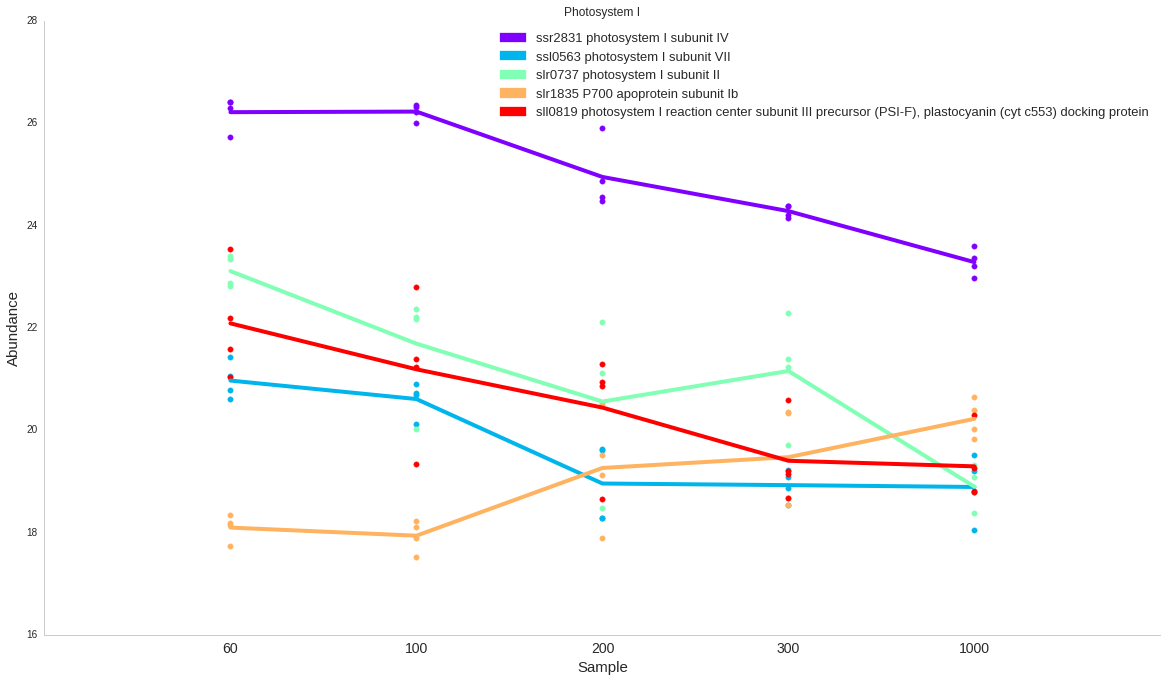

In [27]:
abundance_plot("Photosystem I")

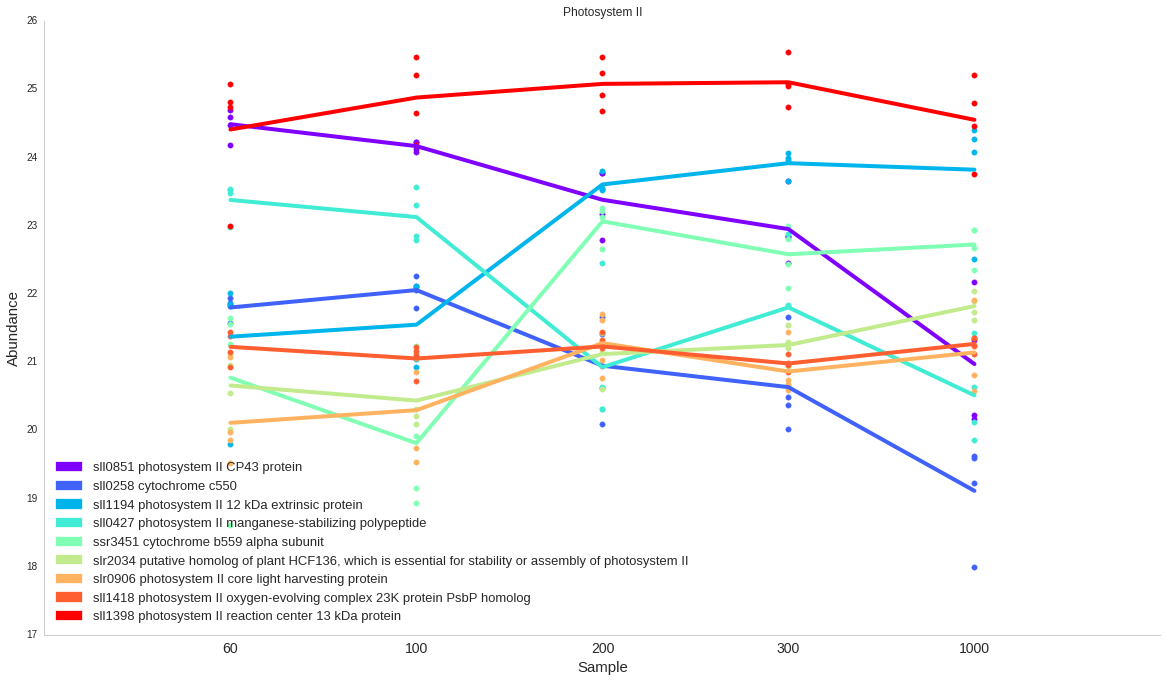

In [28]:
abundance_plot("Photosystem II")

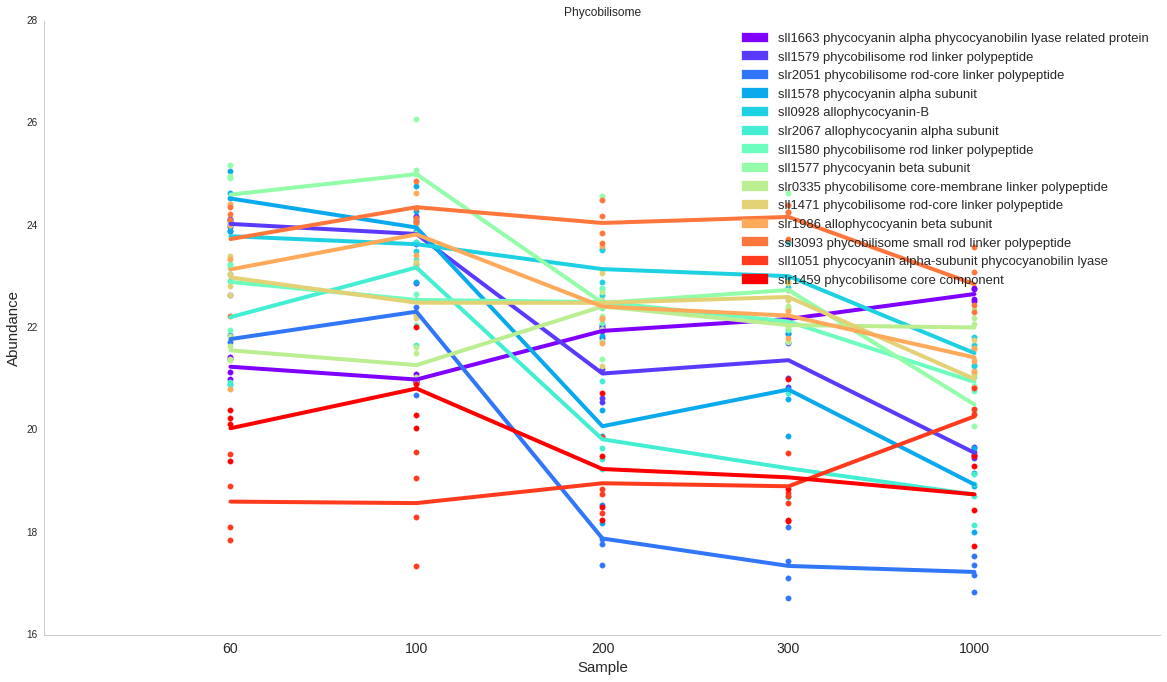

In [29]:
abundance_plot("Phycobilisome")

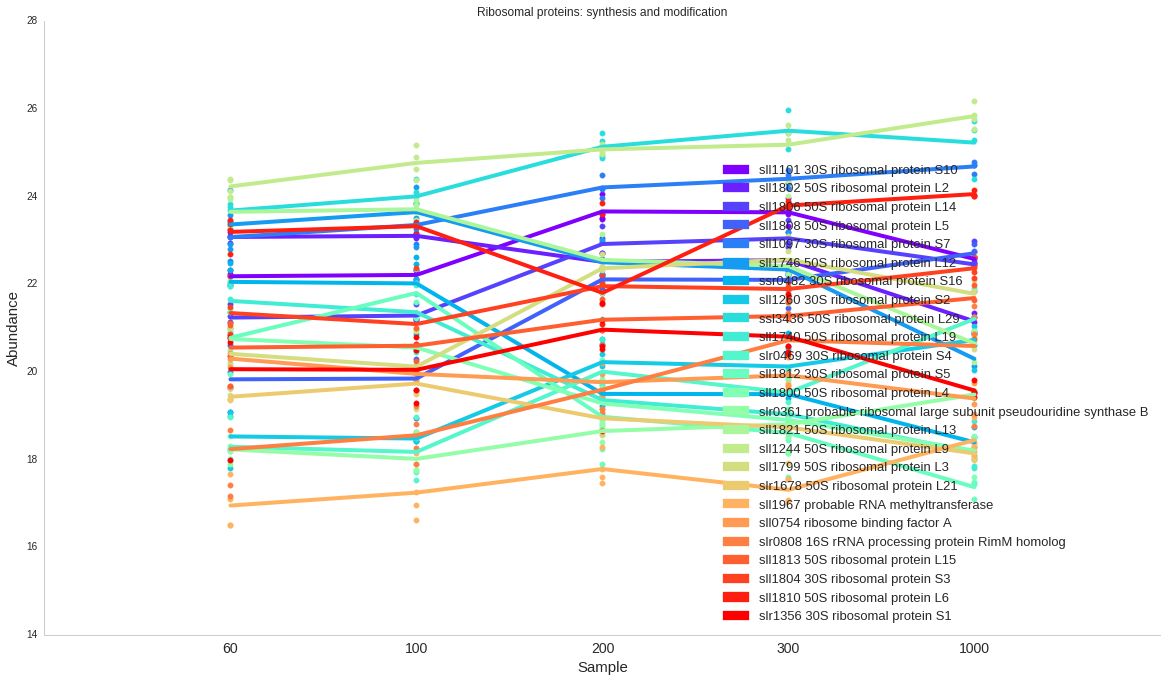

In [30]:
abundance_plot("Ribosomal proteins: synthesis and modification")

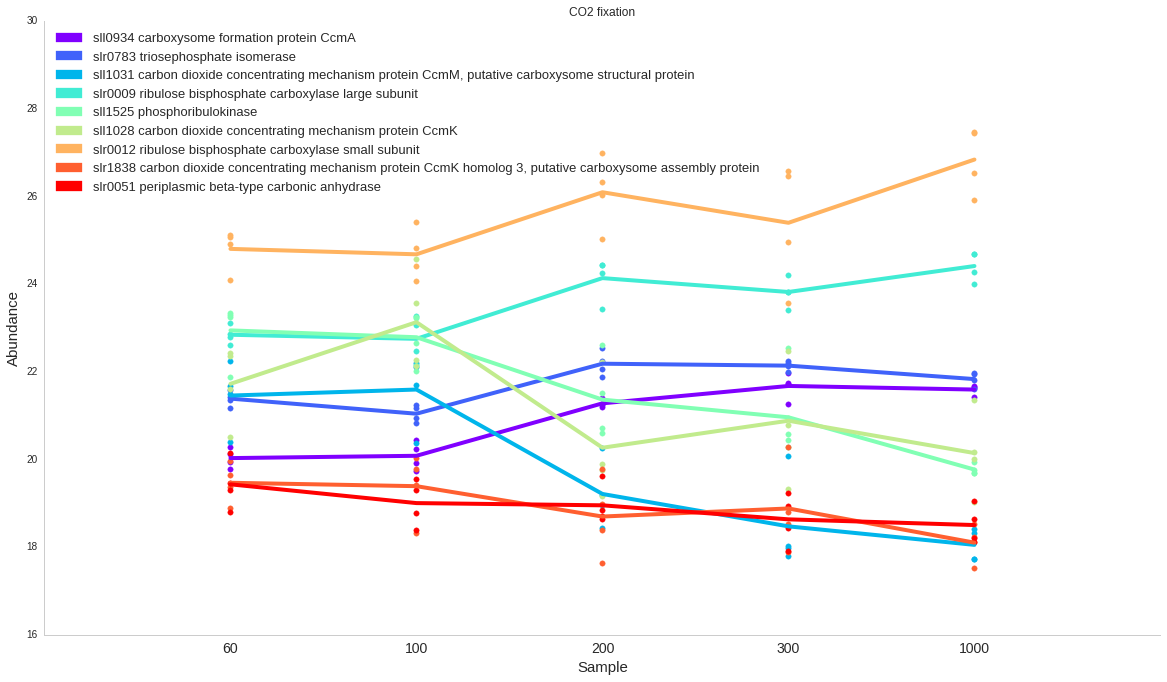

In [31]:
abundance_plot("CO2 fixation")

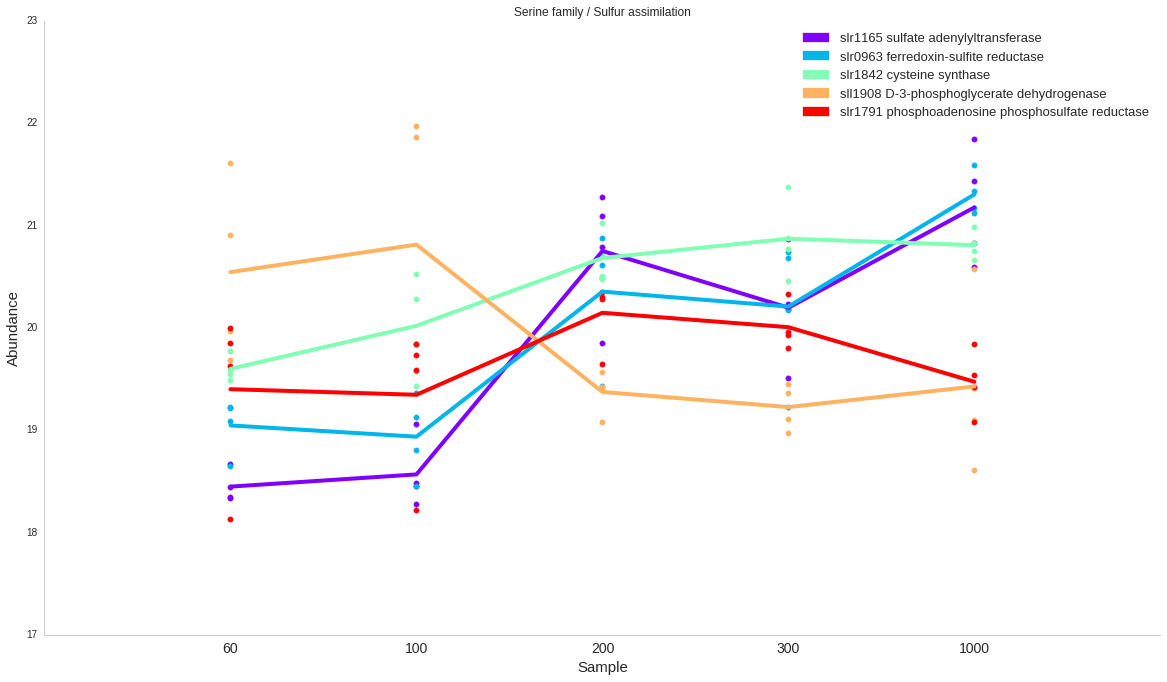

In [32]:
abundance_plot("Serine family / Sulfur assimilation")

### Plot categories as fraction of total protein abundance

In [33]:
#SEE cyano_dataset_20170421_groups_mass_fractions.ipynb

### Annotation enrichment analysis. Cyanobase categories and GO terms

In [34]:
# CyanoBase annotations (first and second 'categories') enrichment analysis: 
def enrich(input_gene_list, background_gene_list, level):
	category_f = "/home/vitalv/database/category.txt"
	category_df = pd.read_csv(category_f, delimiter="\t", header=None, names=["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"])
	data = category_df[category_df["geneID"].isin(input_gene_list)]
	background = category_df[category_df["geneID"].isin(background_gene_list)]
	print "first_category_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" + "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value"
	#if level == "second": data[data.second_category_name.isnull()].second_category_name = ["undefined"]*len(data[data.second_category_name.isnull()])
	for category in data["%s_category_name"%level].unique():
		k = len(data) #input list (list of differentially abundant proteins -ANOVA<0.05-)
		x = len(data[data["%s_category_name"%level] == category]) #num of genes in the input list with the annotation
		N = len(set(background_gene_list)) #background number of genes. One could use the whole genome OR better yet, the set of detected (over a certain threshold) proteins
		m = len(background[background["%s_category_name"%level] == category])
		p = stats.hypergeom.sf(x, N, k, m)
		print str(category) + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)

In [35]:
enrich(list(data_anova.geneID), set(all_prots), "first")

first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	32	497	83	2101	0.00062851745482
Biosynthesis of cofactors, prosthetic groups, and carriers	20	497	89	2101	0.548000859614
Cell envelope	14	497	50	2101	0.182469080645
Cellular processes	22	497	59	2101	0.00556809980897
Central intermediary metabolism	13	497	26	2101	0.000790005849484
Energy metabolism	34	497	79	2101	3.05652237933e-05
Fatty acid, phospholipid and sterol metabolism	10	497	26	2101	0.0265927928352
Photosynthesis and respiration	46	497	92	2101	4.68243388046e-09
Purines, pyrimidines, nucleosides, and nucleotides	17	497	40	2101	0.00222716962611
Regulatory functions	16	497	102	2101	0.969668844147
DNA replication, restriction, modification, recombination, and repair	11	497	47	2101	0.43595180696
Transcription	11	497	23	2101	0.00269416227019
Translation	67	497	154	2101	4.40646632208e-09
Transport and binding pr

In [36]:
enrich(list(data_anova.geneID), set(all_prots), "second")

first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Aromatic amino acid family	5	497	22	2101	0.423917430532
Aspartate family	5	497	11	2101	0.0261067988482
Branched chain family	6	497	12	2101	0.0102089092552
Glutamate family / Nitrogen assimilation	11	497	29	2101	0.0252080372661
Serine family / Sulfur assimilation	5	497	9	2101	0.00736619210695
Biotin	1	497	2	2101	0.0558718070759
Folic acid	1	497	3	2101	0.141263306408
Cobalamin, heme, phycobilin and porphyrin	9	497	32	2101	0.205610431448
Molybdopterin	1	497	3	2101	0.141263306408
Riboflavin	1	497	4	2101	0.239129779309
Thioredoxin, glutaredoxin, and glutathione	4	497	15	2101	0.269477141048
Thiamin	1	497	3	2101	0.141263306408
Carotenoid	1	497	7	2101	0.521226246648
Nicotinate and nicotinamide	1	497	4	2101	0.239129779309
Membranes, lipoproteins, and porins	2	497	6	2101	0.148455881363
Murein sacculus and peptidoglycan	8	497	21	2101	0.03995325979

In [37]:
def enrichGO(input_gene_list, background_gene_list, ontology):
	'''
	#ontology is one of : Biological Process, Molecular Function or Cellular Component
	'''
	go_terms_f = "/home/vitalv/database/goterm.txt"
	go_df = pd.read_csv(go_terms_f, delimiter="\t", header=None, names=["species", "geneID", "annotation_type", "go_term"])
	data_go = go_df[go_df["geneID"].isin(input_gene_list)]
	data = data_go[data_go.go_term.str.contains(ontology, case=False)]
	background = go_df[go_df["geneID"].isin(set(all_prots))]
	background = background[background.go_term.str.contains(ontology, case=False)]
	enrichGO_pvalues = []
	with open("enrichGO.txt", "wb") as f:
		f.write("GO_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" + "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value" + "\n")
		for annotation in data.go_term.unique():
			k = len(data.geneID.unique())
			x = len(data[data.go_term == annotation])
			N = len(set(all_prots))
			m = len(background[background.go_term == annotation])
			p = stats.hypergeom.sf(x, N, k, m)
			#print annotation + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)
			enrichGO_pvalues.append(p)
			f.write(annotation + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p) + "\n")
	return enrichGO_pvalues


In [38]:
enrichGO_pvalues = enrichGO(list(data_anova.geneID), set(all_prots), "biological process")
enrichGO_df = pd.read_csv("enrichGO.txt", delimiter="\t")
#http://statsmodels.sourceforge.net/devel/generated/statsmodels.sandbox.stats.multicomp.multipletests.html
#statsmodels.sandbox.stats.multicomp.multipletests(pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)
'''
`bonferroni` : one-step correction
`sidak` : one-step correction
`holm-sidak` : step down method using Sidak adjustments
`holm` : step-down method using Bonferroni adjustments
`simes-hochberg` : step-up method  (independent)
`hommel` : closed method based on Simes tests (non-negative)
`fdr_bh` : Benjamini/Hochberg  (non-negative)
`fdr_by` : Benjamini/Yekutieli (negative)
`fdr_tsbh` : two stage fdr correction (non-negative)
`fdr_tsbky` : two stage fdr correction (non-negative)
'''
reject, adj_pvalues, corrected_a_sidak, corrected_a_bonf =  mc.multipletests(enrichGO_df["p-value"], method='fdr_bh')
enrichGO_df["adj_pval(BH)"] = adj_pvalues

HTML(enrichGO_df.to_html())



,GO_annotation,Genes in input list w/ annotation,Genes in input list,Genes in background list w/ annotation,Genes in background list,p-value,adj_pval(BH)
0,Biological Process: peptidoglycan turnover (GO...,1,357,2,2101,2.880533e-02,4.024575e-02
1,Biological Process: tetrapyrrole biosynthetic ...,3,357,5,2101,3.556633e-03,6.869183e-03
2,Biological Process: glycolysis (GO:0006096),7,357,12,2101,1.698871e-04,3.637800e-04
3,Biological Process: metabolic process (GO:0008...,68,357,217,2101,9.832813e-09,2.278899e-08
4,Biological Process: isoprenoid biosynthetic pr...,2,357,6,2101,6.519377e-02,8.619578e-02
5,Biological Process: oxidation reduction (GO:00...,49,357,143,2101,5.069257e-08,1.161214e-07
6,Biological Process: nucleotide-excision repair...,2,357,4,2101,1.702109e-02,2.771202e-02
7,Biological Process: protein metabolic process ...,6,357,7,2101,3.893474e-06,8.716073e-06
8,Biological Process: regulation of transcriptio...,13,357,83,2101,5.596206e-01,5.741941e-01
9,Biological Process: two-component signal trans...,9,357,60,2101,5.820845e-01,5.941484e-01


### Clustering 

In [39]:
#convert back to linear space:
matrix =  2**data[samples].values
#or not
matrix = data[samples].values
#or use z_scores:
for s in samples:
	data[s + "_z"] = (data[s] - data[s].mean()) / data[s].std()
z_scores = [z for z in data.columns if "_z" in z]
matrix = data[z_scores]
#or maybe divide by the average across samples?
data[s] / data[samples].mean(axis=1)

0      1.035405
1      1.031457
2      1.027219
3      1.012735
4      0.895338
5      0.983700
6      0.905378
7      1.077586
8      1.033089
9      1.043451
10     0.918937
11     1.050875
12     1.069410
13     1.043844
14     0.871754
15     1.102623
16     1.056361
17     1.015977
18     1.054864
19     1.053564
20     1.068432
21     1.044988
22     1.038795
23     0.957692
24     1.074578
25     1.065999
26     1.034177
27     1.059214
28     1.035508
29     0.939992
         ...   
509    0.996252
510    0.959058
511    0.971979
512    0.989947
513    1.011445
514    1.009872
515    1.050070
516    1.019078
517    0.950434
518    1.004546
519    1.020324
520    0.991704
521    1.007937
522    0.999268
523    0.990006
524    0.996553
525    1.005903
526    1.001778
527    1.001713
528    0.995595
529    0.982427
530    0.997160
531    1.007762
532    1.021630
533    1.007477
534    1.046923
535    1.064702
536    1.009951
537    1.014730
538    1.006040
dtype: float64

In [40]:
#Hierarchical clustering function with method and distance metric passed as arguments
def hcluster(matrix, method='complete', metric='euclidean', dendro_color_threshold=0.7): #default dendro_color_threshold = 0.7 #0.45
	fig = plt.figure(figsize=(18,10))
	#First dendrogram. Rows. Genes.
	D = dist.pdist(matrix, metric=metric) #Pairwise distances between observations in n-dimensional space.
	D = dist.squareform(D)
	ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
	Y = sch.linkage(D, method=method, metric=metric) #Performs hierarchical/agglomerative clustering.
	#Z1 = sch.dendrogram(Y, orientation='left', link_color_func=plt.cm.rainbow,  color_threshold=dendro_color_threshold*max(Y[:,2])) #colors all descendent links below a cluster node k the same color if k is the first node below the cut threshold
	Z1 = sch.dendrogram(Y, orientation='left', color_threshold=dendro_color_threshold*max(Y[:,2])) #, count_sort=True, distance_sort=False) #count sort and dist sort cant both be true 
	#Z1 = sch.dendrogram(Y, truncate_mode='lastp', p=5, orientation='left', color_threshold=dendro_color_threshold*max(Y[:,2])) 
	ax1.set_xticks([])
	ax1.set_yticks([])
	ax1.axis('off')
	#Second dendrogram. Columns. Samples
	D_samples = dist.pdist(matrix.T, metric=metric)
	D_samples = dist.squareform(D_samples)
	ax2 = fig.add_axes([0.3,0.75,0.6,0.2])
	Y = sch.linkage(D_samples, method=method, metric=metric)
	#for label in ax2.get_xticklabels(): label.set_rotation(45) 
	Z2 = sch.dendrogram(Y, labels=samples, color_threshold=max(Y[:,2]), count_sort='descending')
	#ax2.set_xticks([])
	ax2.set_yticks([])
	#remove outer border(frame)
	ax2.spines['top'].set_visible(False)
	ax2.spines['right'].set_visible(False)
	ax2.spines['bottom'].set_visible(False)
	ax2.spines['left'].set_visible(False)
	# Scale the max and min colors so that 0 is white/black
	#cmap=plt.cm.YlGnBu
	cmap=plt.cm.coolwarm
	vmin = matrix.min()
	vmax = matrix.max()
	#vmax = max([vmax,abs(vmin)])
	vmax = max([vmax.max(), abs(vmin).max()])
	vmin = vmax*-1
	norm = matplotlib.colors.Normalize(vmin/2, vmax/2)
	# Plot heatmap
	axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
	idx1 = Z1['leaves']
	idx2 = Z2['leaves']
	#D = D[idx1,:]
	#D = D[:,idx2]
	#heatmap = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=cmap)#, norm=norm) #use norm if values are log
	M = matrix.values[idx1,:]
	M = matrix.values[:,idx2]
	heatmap = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, norm=norm) #use norm if values are log
	axmatrix.set_xticks([])
	axmatrix.set_yticks([])
	plt.title("method: %s, metric: %s"%(method,metric), x=0.5, y=-0.1)
	# Plot colorbar.
	axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
	colorbar = plt.colorbar(heatmap, cax=axcolor)
	colorbar.set_label("abundance")
	return Z1, Z2, heatmap



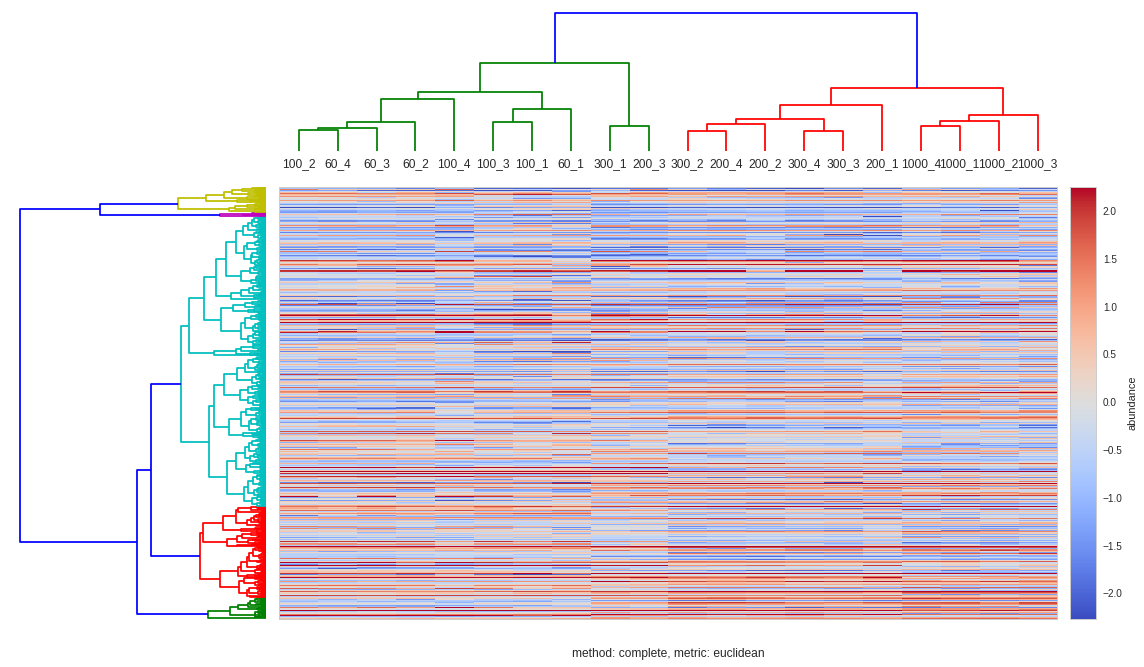

In [41]:
dendroRows_com_euc, dendroCols, heatmap = hcluster(matrix, method='complete', metric='euclidean', dendro_color_threshold=0.45)

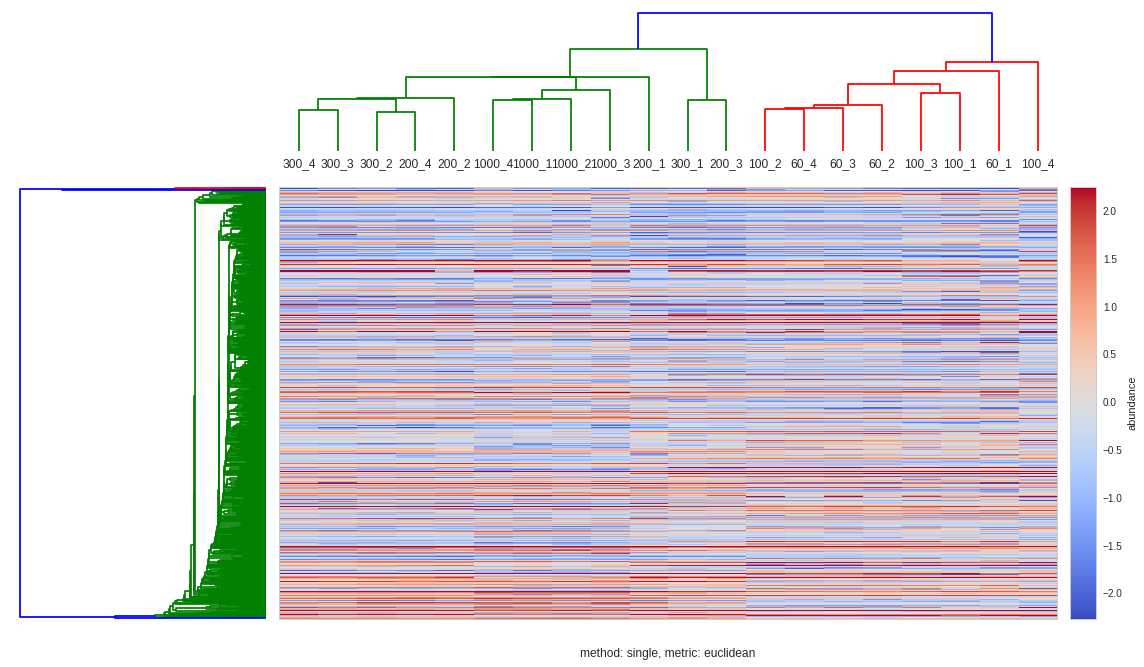

In [42]:
dendroRows_sin_euc, dendroCols, heatmap = hcluster(matrix, method='single', metric='euclidean', dendro_color_threshold=0.45)

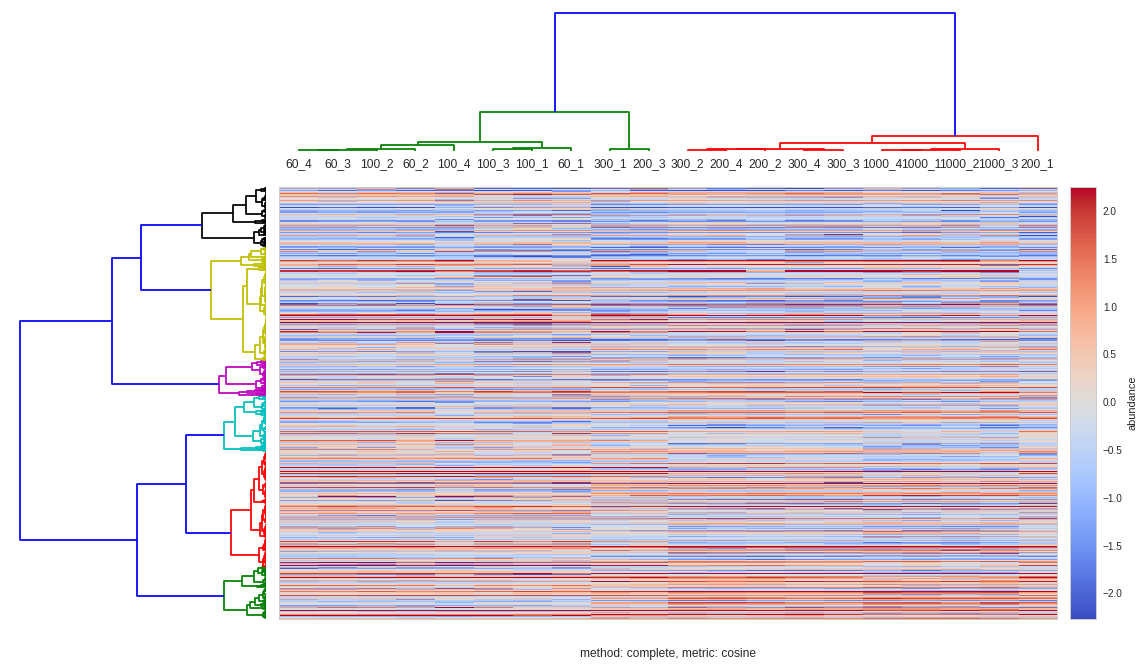

In [49]:
dendroRows_com_cos, dendroCols, heatmap = hcluster(matrix, method='complete', metric='cosine', dendro_color_threshold=0.30)

#### GO enrichment on the clusters

In [50]:
#data_anova is my df with statistically siginficant changing proteins
data = data_anova.reset_index() #Need my data to have the same index as the matrix:

def cluster_enrich(dendroRows, collapse=False):
	#see http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
	cluster_idxs = collections.defaultdict(list)
	for c, pi in zip(dendroRows['color_list'], dendroRows['icoord']):
		for leg in pi[1:3]:
			i = (leg - 5.0) / 10.0
			if abs(i - int(i)) < 1e-5:
				cluster_idxs[c].append(int(i))

	#for  color_threshold=0.45*max(Y[:,2]) in the proteins(rows) dendrogram I get 6 clusters but 3 of them are quite small. Just group them:
	if collapse:
		small_cluster, small_cluster_idxs = [], []
		for color, idxs in cluster_idxs.iteritems():
			if len(idxs) < 30:
				small_cluster.append(color)
				small_cluster_idxs.append(idxs)
		for color in small_cluster: cluster_idxs.pop(color)
		cluster_idxs[''.join(small_cluster)] = [item for sublist in small_cluster_idxs for item in sublist]


	#category_f = "/home/vitalv/cyano/category.txt"
	#category_df = pd.read_csv(category_f, delimiter="\t", header=None)
	#category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
	#cols = ["geneID", "definition", "first_category_name", "second_category_name"]
	#data = pd.merge(data, category_df[cols], left_on='Protein', right_on='geneID', how='left')


	for color, idxs in cluster_idxs.iteritems():
		cluster_proteins = list(data.iloc[cluster_idxs[color],:].Protein)
		cluster_proteins = [protein for protein in cluster_proteins if ";" not in protein]
		print "CLUSTER: %s" % color + " (%s proteins)" %  len(cluster_proteins)
		enrich(cluster_proteins, set(all_prots), "first")
		print "\n"

In [51]:
#Enrichment for clusters from HCL complete linkage / cosine 'distance' metric:
cluster_enrich(dendroRows_com_cos)
#c is cyan
#r is red
#m is magenta
#g is green

CLUSTER: c (71 proteins)
first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	5	70	83	2101	0.0551583896783
Cell envelope	1	70	50	2101	0.502079986145
Cellular processes	4	70	59	2101	0.0441506388314
Central intermediary metabolism	2	70	26	2101	0.0532387102656
Energy metabolism	5	70	79	2101	0.0450581814115
Fatty acid, phospholipid and sterol metabolism	1	70	26	2101	0.213932162433
Photosynthesis and respiration	4	70	92	2101	0.189241724802
Purines, pyrimidines, nucleosides, and nucleotides	3	70	40	2101	0.041853382541
Regulatory functions	1	70	102	2101	0.864150269617
DNA replication, restriction, modification, recombination, and repair	2	70	47	2101	0.204554679314
Transcription	2	70	23	2101	0.0389165910976
Translation	8	70	154	2101	0.0659690496377
Transport and binding proteins	3	70	95	2101	0.390989870699
Other categories	5	70	153	2101	0.401794251328
Hypothetical	20	70	69

IndexError: positional indexers are out-of-bounds

In [48]:
cluster_enrich(dendroRows_com_euc)
#c is cyan
#r is red
#m is magenta
#g is green
#y is yellow

IndexError: positional indexers are out-of-bounds

#### Other clustering methods besides HCL: K-MEANS AND MEAN SHIFT

K-MEANS:  
separate samples in n groups of equal variance  
first step chooses the initial centroids (k, the number of clusters)  
After initialization, K-means consists of looping between the two other steps:  
The first step assigns each sample to its nearest centroid.  
The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid  
The inertia or within-cluster sum-of-squares is minimized  

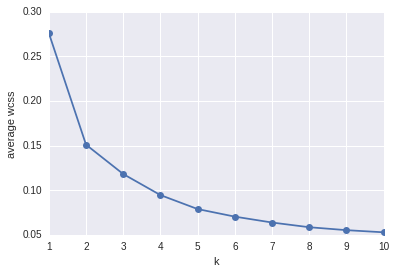

In [43]:
#from sklearn.cluster import KMeans
#from scipy.spatial.distance import pdist,cdist
data = data_anova.reset_index() #Need my data to have the same index as the matrix:

#K-MEANS
# Try to find  optimal number of clusters for k-means. "Elbow" method
k_range = range(1,11)
k_means = [KMeans(n_clusters = k, init='k-means++').fit(matrix) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means]
labels = [X.labels_ for X in k_means]
#calculate Euclidean distance from each point to cluster center
k_euclid = [cdist(matrix, c, 'euclidean') for c in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
#Total within cluster sum of squares
wcss = [sum(d**2) for d in dist]
#average wcss
avwcss = [(sum(d**2))/len(d) for d in dist]
#total sum of squares
tss = sum(pdist(matrix)**2)/matrix.shape[0]
#between cluster sum of squares:
bss = tss - wcss
#plot average wcss vs number of clusters "Elbow plot": look for a point where the rate of decrease in wcss sharply shifts
plt.plot(k_range, avwcss, '-o')
plt.ylabel("average wcss")
plt.xlabel("k")

#### Silhouette plots
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters. Provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].  

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters.  

A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters  
and negative values indicate that those samples might have been assigned to the wrong cluster.  

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)  


In [44]:
#idxs = list(cluster_idxs[2][0]) #take for example proteins from cluster number 3
#kmeans_cluster3 = data.iloc[idxs, :].Protein
def cluster_abundance(protein_idxs, ax=None):
	protein_set = data[data["Protein"].isin(data.iloc[idxs, :].Protein)]
	X = range(1, num_samples+1)
	samples_ = [s.split("_")[0] for s in samples]
	x_labels = sorted(set(samples_), key=samples_.index)
	nCols = len(X)
	color_patches = []
	if not ax:
		fig, ax = plt.subplots()
	color=iter(plt.cm.rainbow(np.linspace(0,1,len(protein_set))))
	for i, row in protein_set.iterrows():
		Ys = row[samples].values.reshape(num_samples,num_replica).T #for scatter
		nRows = Ys.shape[0]
		Xs=X*nRows
		ax.plot(X, row[means].values, "-", color='gray')
	medians = protein_set[means].median(axis=0)
	ax.plot(X, medians, "-", color='red')
	ax.set_ylabel("Abundance", fontsize=9)
	ax.set_title("", fontsize=10)
	ax.set_xticks(X)
	ax.set_xlabel("Sample", fontsize=9)
	ax.set_xticklabels(list(x_labels), fontsize=9)

n_clusters: 2 Average silhouette_score is : 0.37823491098
n_clusters: 3 Average silhouette_score is : 0.265963152282
n_clusters: 4 Average silhouette_score is : 0.295484089503
n_clusters: 5 Average silhouette_score is : 0.283806094671


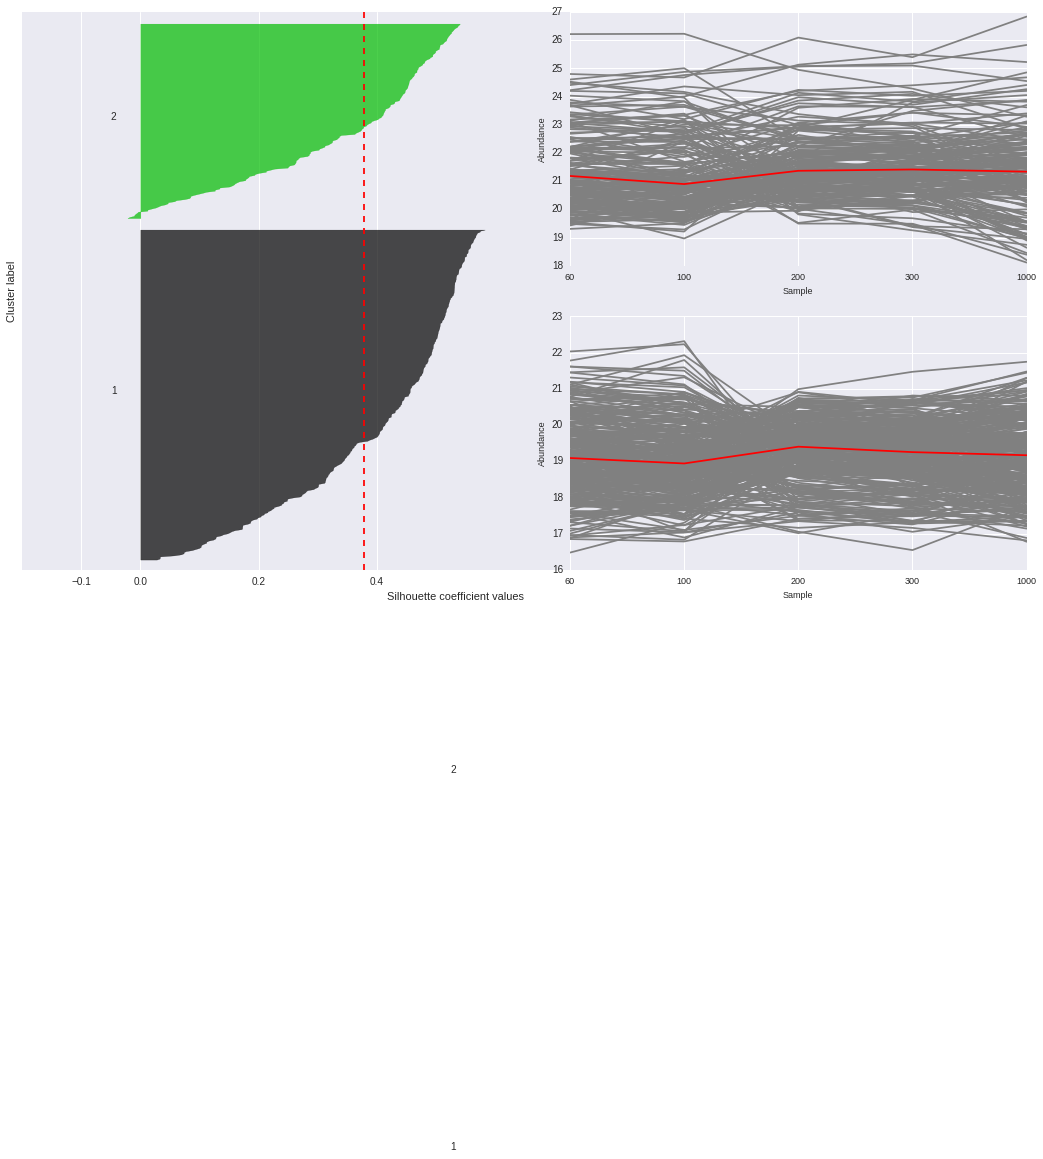

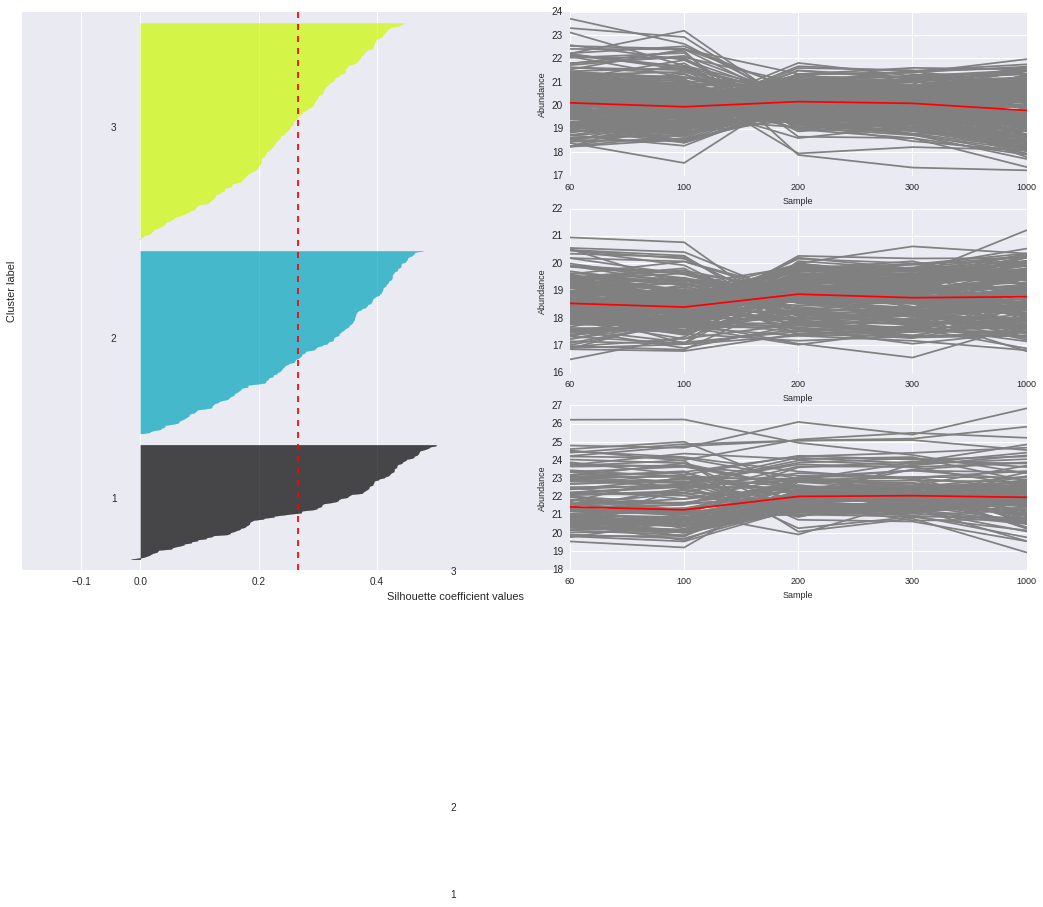

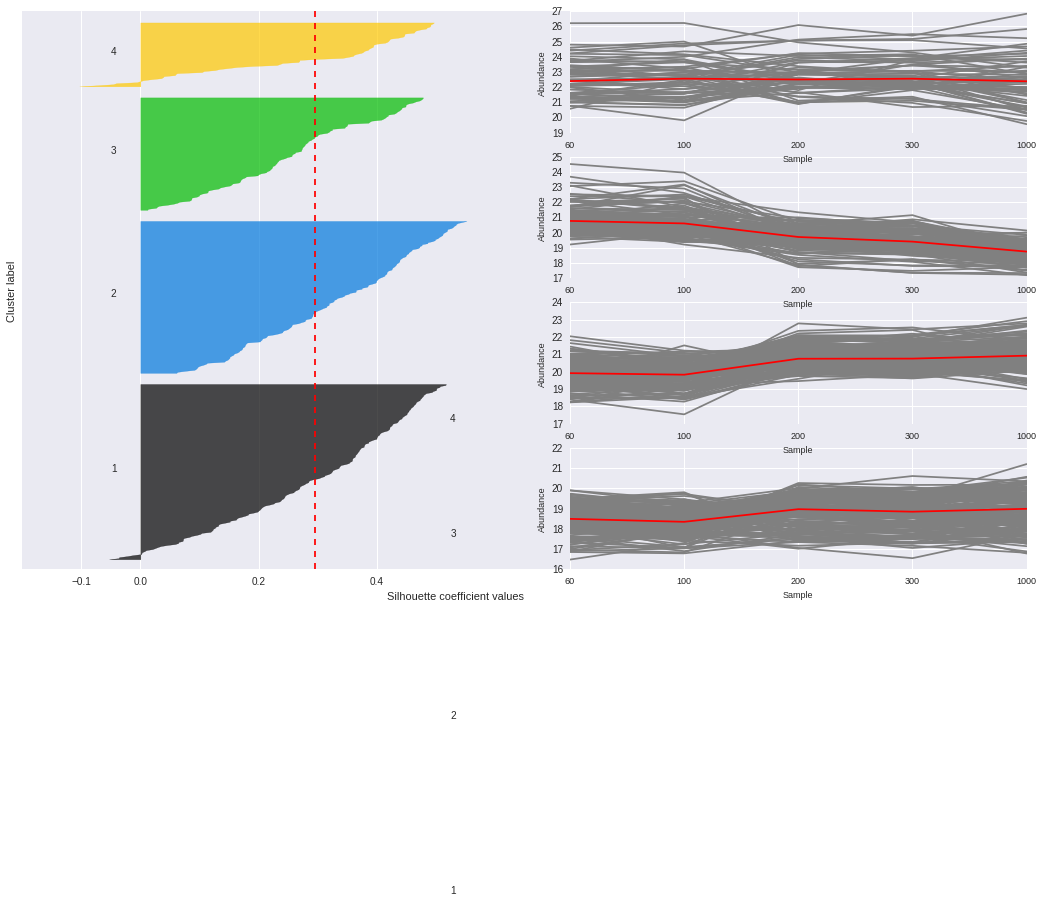

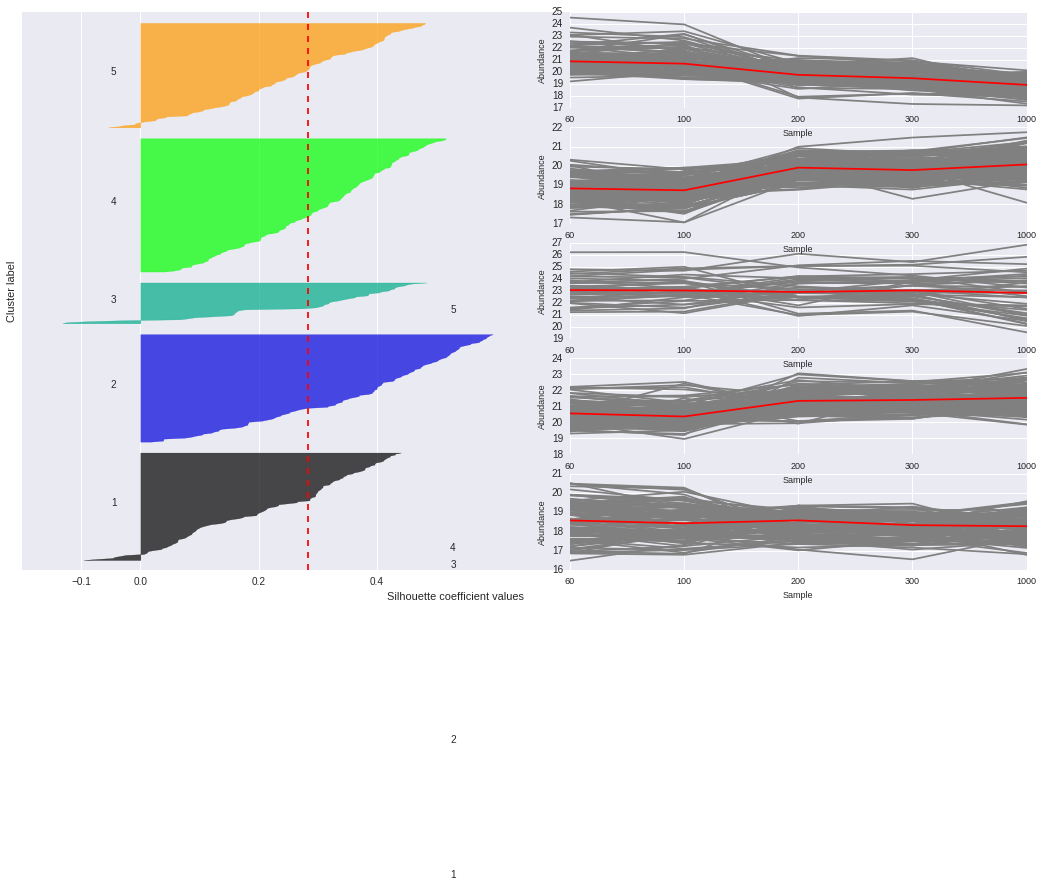

In [45]:
#Silhouette coefficients and plots ----------------------------------------------------------------------------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
range_n_clusters = range(2,6)
for n_clusters in range_n_clusters:
	fig, ax1 = plt.subplots(figsize=(18,10))
	#fig, (ax1, ax2) = plt.subplots(1, 2) # Create a subplot with 1 row and 2 columns
	ax1.set_xlim([-0.2, 1.5]) 
	ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10]) #inserts blank space between silhouette plots of individual cluster
	# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
	kmeans = KMeans(n_clusters=n_clusters, init='k-means++')#, random_state=10) 
	cluster_labels = kmeans.fit_predict(matrix)
	silhouette_avg = silhouette_score(matrix, cluster_labels) # The silhouette_score gives the average value for all the samples.
	print "n_clusters:", n_clusters, "Average silhouette_score is :", silhouette_avg
	sample_silhouette_values = silhouette_samples(matrix, cluster_labels) # Compute the silhouette scores for each sample
	cluster_idxs = {}
	y_lower = 10
	for i in range(n_clusters):
		c = cluster_labels == i
		cluster_idxs[i] = np.where(c==True)
		ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]# Aggregate silhouette scores for samples belonging to cluster i, 
		ith_cluster_silhouette_values.sort() #and sort them
		size_cluster_i = ith_cluster_silhouette_values.shape[0]
		y_upper = y_lower + size_cluster_i
		color = cm.spectral(float(i) / n_clusters)
		ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
		ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1)) # Label the silhouette plots with their cluster numbers at the middle
		y_lower = y_upper + 10  # # Compute the new y_lower for next plot 10 for the 0 samples
		position=range(n_clusters)[-(i+1)]*2+2
		ax_n = fig.add_subplot(n_clusters,2,position) #add_subplot(rows,columns,positionInGrid)
		ax_n.text(-0.05,0,str(i+1))
		idxs = list(cluster_idxs[i][0])
		cluster_abundance(idxs, ax=ax_n)
	ax1.set_xlabel("Silhouette coefficient values", horizontalalignment='right')
	ax1.set_ylabel("Cluster label")
	ax1.axvline(x=silhouette_avg, color="red", linestyle="--")# Vertical line for average silhouette score of all the values
	ax1.set_yticks([])  # Clear the yaxis labels / ticks
	ax1.set_xticks([-0.1, 0, 0.2, 0.4])

#### Mean Shift

Mean shift has the advantage that it does not require a pre-defined number of clusters  

Updates centroid candidates in each iteration so they become the mean of the points within a region of size determined by the paramater bandwidth  

The mean shift vector is computed for each centroid and points towards a region of the maximum increase in the density of points

In [44]:
#MEAN SHIFT ################################################################################################
from sklearn.cluster import MeanShift, estimate_bandwidth

#bandwidth dictates the size of the region to search through. (Also called attractive/gravitational interaction length) Can be set manually
#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html
bandwidth = estimate_bandwidth(matrix, quantile=0.3)#, n_samples=200) #default: quantile=0.3, n_samples= (all samples are used)
#quantile=0.5 means that the median of all pairwise distances is used
#but it takes a default value if bandwidth is not set

#set seeds to k-means centroids to try the kmeans+mean_shift combined approach from http://jamesxli.blogspot.se/2012/03/on-mean-shift-and-k-means-clustering.html
#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
#If bin_seeding=true, initial kernel locations are not locations of all points, but rather the location of the discretized version of points, 
#where points are binned onto a grid whose coarseness corresponds to the bandwidth. Setting this option to True will speed up the algorithm because fewer seeds will be initialized
ms = MeanShift(bandwidth=bandwidth)
#ms = MeanShift()
ms.fit(matrix)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

cluster_idxs = {}
for cluster in range(n_clusters_):
	c = labels == cluster
	cluster_idxs[cluster] = np.where(c == True)

In [48]:
enrich(data.iloc[cluster_idxs[1][0],:].Protein, set(all_prots), "first")

KeyError: 1

In [46]:
enrich(data.iloc[cluster_idxs[2][0],:].Protein, set(all_prots), "first")

KeyError: 2

In [ ]:
enrich(data.iloc[cluster_idxs[3][0],:].Protein, set(all_prots), "first")

#### tSNE
tSNE is a dimensionality reduction technique useful for visualizing high-dimensional data  

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE  
https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm  

The learning rate can be a critical parameter. It should be between 100 and 1000. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high. If the cost function gets stuck in a bad local minimum increasing the learning rate helps sometimes
random_state is Pseudo Random Number generator seed control.
If None, use the numpy.random singleton. Note that different initializations might result in different local minima of the cost function.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE
#defaults:
#tsne = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000) #learning_rate is also called epsilon

RS = 20150101#random_state is Pseudo Random Number generator seed control. 
#If None, use the numpy.random singleton. Note that different initializations might result in different local minima of the cost function.
#tsne = TSNE(random_state=RS).fit_transform(matrix) 

#Plot first_category_name---------------------------------------------------------------------------------
matrix = data_anova.sort("first_category_name")[samples].values
labels = np.array(data_anova.sort("first_category_name").first_category_name)

tsne_rs = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, random_state=RS, verbose=1).fit_transform(matrix)
tsne_cos = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, metric='cosine', verbose=1).fit_transform(matrix)

label_color_ = {}
for i in range(len(np.unique(labels))):
	label = np.unique(labels)[i]
	label_color_[label] = i
colors = np.array([label_color_[label] for label in labels])

def scatter(x, colors, nclasses):
	palette = np.array(sb.color_palette("hls", nclasses )) # color palette with seaborn.
	f = plt.figure(figsize=(8, 8))
	ax = plt.subplot(aspect='equal')
	sc = ax.scatter(x[:,0], x[:,1], linewidth=0, s=40, color=palette[colors.astype(np.int)])
	plt.xlim(-25, 25)
	plt.ylim(-25, 25)
	#ax.axis('off')
	ax.axis('tight')
	txts = []
	for i in range(nclasses):
		# Position of each label.
		xtext, ytext = np.median(x[colors == i, :], axis=0)
		txt = ax.text(xtext, ytext, str(i), fontsize=18)
		#txt.set_path_effects([
		#	PathEffects.Stroke(linewidth=5, foreground="w"),
		#	PathEffects.Normal()])
		txts.append(txt)
	return f, ax, sc, txts

In [ ]:
scatter(tsne_cos, colors, len(set(colors)))

In [ ]:
scatter(tsne_rs, colors, len(set(colors)))

In [ ]:
#Plot clusters from k-means ------------------------------------------------------------------------------------------------
matrix =  2**data_anova[samples].values
for k in range(2,5):
	kmeans = KMeans(n_clusters=5, init='k-means++')#, random_state=10) 
	cluster_labels = kmeans.fit_predict(matrix)
	tsne = TSNE(n_components=2, perplexity=30, learning_rate=1000, n_iter=1000, metric='cosine', verbose=0).fit_transform(matrix)
	scatter(tsne, cluster_labels, len(set(cluster_labels)))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit_transform(matrix)
ax = plt.subplot(aspect='equal')

ax.scatter(pca[:,0], pca[:,1])